In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np

In [2]:
import cv2
import csv
import pandas as pd

In [3]:
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from PIL import Image
import os
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary

# Работа с данными

## Считывание данных

### Считываем изображения

In [4]:
img_dir = r"./Dataset/formula_images/"
img_cropped_dir = r"./Dataset/formula_images_cropped/"
formulas_dir = r"./Dataset/"

In [99]:
import os
images = os.listdir(img_dir)

In [100]:
images_full_path = [img_dir + img for img in images]
images_cropped_full_path = [img_cropped_dir + img for img in images]

### Делаем crop изображений и сохраняем в другую директорию

In [37]:
x0 = 300
x1 = 600

In [ ]:
for img_path, img_cropped_path in zip(images_full_path, images_cropped_full_path):
    img = cv2.imread(img_path)
    cv2.imwrite(img_cropped_path, img[x0:x1, :])

### Считываем формулы

In [5]:
formulas = {}

In [6]:
with open(formulas_dir + "im2latex_formulas.lst", newline="\n", encoding='latin-1') as file:
    for idx, line in enumerate(file, start=0):
        formulas[idx] = line.strip()

In [7]:
all_characters = set()

In [8]:
with open(formulas_dir + "SYMLIST.txt", newline='\n') as file:
    for idx, line in enumerate(file, start=0):
        all_characters.add(line[:-1])

In [9]:
len(all_characters)

16482

In [10]:
characters = set()

In [11]:
for idx, formula in tqdm(formulas.items()):
    for lat_char in all_characters:
        if lat_char in formula:
            characters.add(lat_char)

100%|██████████| 104546/104546 [03:12<00:00, 542.19it/s]


In [12]:
len(characters)

467

In [13]:
with open(formulas_dir + "dict.txt", newline='\n') as file:
    for idx, line in enumerate(file, start=0):
        characters.add(line[:-1])

In [14]:
len(characters)

537

In [15]:
characters_copy = characters.copy()

In [16]:
for character in characters_copy:
    if ('{' in character or '}' in character) and len(character) > 1:
        characters.remove(character)
        

In [17]:
characters_copy = characters.copy()

In [18]:
for character in characters_copy:
    characters.remove(character)
    characters.add(character.lower())

In [19]:
greek = ("\\Alpha", "\\Beta", "\\Gamma", "\\Delta", "\\Epsilon", "\\Zeta", "\\Eta", "\\Theta", "\\Iota", "\\Kappa", "\\Lambda", "\\Mu",
         "\\Nu", "\\Xi", "\\Omicron", "\\Pi", "\\Rho", "\\Sigma", "\\Tau", "\\Upsilon", "\\Phi", "\\Chi", "\\Psi", "\\Omega")
eng = ("A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z")

In [20]:
characters.update(greek)
characters.update(eng)

In [21]:
len(characters)

435

In [30]:
characters.add(":")
characters.add(";")
characters.add("~")
characters.add("&")
characters.add("%")
characters.add("$")
characters.add("@")
characters.add('"')
characters.add('`')
characters.add('?')
characters.add('#')
characters.add(' ')

characters.add('ç')
characters.add('¥')
characters.add('')
characters.add('§')
characters.add('')

In [32]:
vocab = {}
vocab_r = {}

In [34]:
for idx, character in enumerate(characters):
    vocab[character] = idx
    vocab_r[idx] = character

In [35]:
len(vocab)

452

In [50]:
vocab_dict = {"idx": list(vocab.values()), "character": list(vocab.keys())}

In [52]:
vocab_df = pd.DataFrame.from_dict(vocab_dict)

In [54]:
vocab_df.to_csv("vocab.csv", sep="\t")

In [353]:
def tok_to_str(tok_list, vocab_r):
    st = ""
    for tok in tok_list:
        st = st + vocab_r[tok]
        
    return st

In [44]:
'_' in characters

True

In [59]:
formulas = {}

In [60]:
with open(formulas_dir + "im2latex_formulas.lst", newline="\n", encoding='latin-1') as file:
    for idx, line in enumerate(file, start=0):
        formulas[idx] = line.strip()

In [61]:
for idx in tqdm(range(len(formulas.items()))):
    tok_list = encode_truth(formulas[idx], vocab)

  7%|▋         | 7252/104546 [00:23<05:12, 311.73it/s]


KeyboardInterrupt: 

In [56]:
formulas[100000]

'\\label{oneterm}{\\cal Z}^{(2)}_1 = \\int d^{10} A_3 (J^3)^{16} e^{-V(|A_3|)}'

In [57]:
len(formulas)

104546

In [58]:
tok_to_str(tok_list, vocab_r)

KeyError: '<sos>'

### Создаём словарь {путь к изображению: формула}

In [104]:
train_data = pd.read_csv(formulas_dir + "im2latex_train.lst", delimiter=" ", header=None)
train_data.columns = ['formula_idx', 'img_path', 'type']
train_data["img_path"] = train_data["img_path"].apply(lambda x: img_cropped_dir + x + ".png")

train_dataset_dict = {}
for index, row in train_data.iterrows():
    train_dataset_dict[row["img_path"]] = formulas[row["formula_idx"]]

In [160]:
val_data = pd.read_csv(formulas_dir + "im2latex_validate.lst", delimiter=" ", header=None)
val_data.columns = ['formula_idx', 'img_path', 'type']
val_data["img_path"] = val_data["img_path"].apply(lambda x: img_cropped_dir + x + ".png")

val_dataset_dict = {}
for index, row in val_data.iterrows():
    val_dataset_dict[row["img_path"]] = formulas[row["formula_idx"]]

In [161]:
test_data = pd.read_csv(formulas_dir + "im2latex_test.lst", delimiter=" ", header=None)
test_data.columns = ['formula_idx', 'img_path', 'type']
test_data["img_path"] = test_data["img_path"].apply(lambda x: img_cropped_dir + x + ".png")

test_dataset_dict = {}
for index, row in test_data.iterrows():
    test_dataset_dict[row["img_path"]] = formulas[row["formula_idx"]]

## Добавление аугментаций 

### Добавляем только аугментации, не искажающие сами формулы: поворот, смещение, масштабирование, небольшой blur

In [150]:
import albumentations as A
import random

In [151]:
transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.75, rotate_limit=20, p=1.0),
    A.Blur(blur_limit=3)
])

In [ ]:
for i in range(int(0.5 * len(train_dataset_dict))):
    img_path, formula = random.choice(list(train_dataset_dict.items()))
    
    aug_name = "a" + str(i) + ".png"
    
    aug_path = img_cropped_dir + aug_name
    
    img = cv2.imread(img_path)
    
    aug_img = transform(image=img)['image']
    
    cv2.imwrite(aug_path, aug_img)
    
    train_dataset_dict[aug_path] = formula

### Сохраняем получившиеся словари в csv-файлы

In [195]:
tf_train = {"img_path": list(train_dataset_dict.keys()), "formula": list(train_dataset_dict.values())}
tf_val = {"img_path": list(val_dataset_dict.keys()), "formula": list(val_dataset_dict.values())}
tf_test = {"img_path": list(test_dataset_dict.keys()), "formula": list(test_dataset_dict.values())}

NameError: name 'train_dataset_dict' is not defined

In [196]:
train_dataset_df = pd.DataFrame.from_dict(tf_train)
val_dataset_df = pd.DataFrame.from_dict(tf_val)
test_dataset_df = pd.DataFrame.from_dict(tf_test)

In [197]:
train_dataset_df.to_csv(formulas_dir + "train_dict.csv", sep="к")
val_dataset_df.to_csv(formulas_dir + "val_dict.csv", sep="к")
test_dataset_df.to_csv(formulas_dir + "test_dict.csv", sep="к")

## Создание Dataset'ов и Dataloader'ов

### Считываем словари {путь к изображению: формула}

In [5]:
START = "<SOS>"
END = "<EOS>"
PAD = "<PAD>"
SPECIAL_TOKENS = [START, END, PAD]

In [6]:
img_dir = r"./Dataset/formula_images/"
img_cropped_dir = r"./Dataset/formula_images_cropped/"
formulas_dir = r"./Dataset/"

In [7]:
def load_vocab(tokens_file):
    with open(tokens_file, "r") as fd:
        tokens = []
        df = pd.read_csv(tokens_file, sep='\t')
        for index, row in df.iterrows():
            tokens.append(row["character"])
        tokens.extend(SPECIAL_TOKENS)
        token_to_id = {tok: i for i, tok in enumerate(tokens)}
        id_to_token = {i: tok for i, tok in enumerate(tokens)}
        return token_to_id, id_to_token

In [8]:
token_to_id, id_to_token = load_vocab("vocab.csv")

In [9]:
def encode_truth(truth, token_to_id):
    
    truth_tokens = []
    remaining_truth = truth
    while len(remaining_truth) > 0:
        try:
            matching_starts = [
                [i, len(tok)]
                for tok, i in token_to_id.items()
                if remaining_truth.startswith(tok)
            ]
            # Take the longest match
            index, tok_len = max(matching_starts, key=lambda match: match[1])
            truth_tokens.append(index)
            remaining_truth = remaining_truth[tok_len:].lstrip()
        except ValueError:
            print(truth)
            raise Exception("Truth contains unknown token")

    return truth_tokens

In [10]:
train_dataset_df = pd.read_csv(formulas_dir + "train_dict.csv", delimiter="к")
train_dataset_dict = {}
for index, row in tqdm(train_dataset_df.iterrows()):
    train_dataset_dict[row["img_path"]] = {"truth": row["formula"], 
                                           "encoded": [token_to_id[START], *encode_truth(row["formula"], token_to_id), token_to_id[END]]}

C:\Users\Egor\AppData\Local\Temp\ipykernel_32524\3439078064.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  train_dataset_df = pd.read_csv(formulas_dir + "train_dict.csv", delimiter="к")
127521it [06:28, 327.91it/s]


In [11]:
val_dataset_df = pd.read_csv(formulas_dir + "val_dict.csv", delimiter="к")
val_dataset_dict = {}
for index, row in tqdm(val_dataset_df.iterrows()):
    val_dataset_dict[row["img_path"]] = {"truth": row["formula"], 
                                         "encoded": [token_to_id[START], *encode_truth(row["formula"], token_to_id), token_to_id[END]]}

C:\Users\Egor\AppData\Local\Temp\ipykernel_32524\81229163.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  val_dataset_df = pd.read_csv(formulas_dir + "val_dict.csv", delimiter="к")
9317it [00:26, 348.96it/s]


In [12]:
test_dataset_df = pd.read_csv(formulas_dir + "test_dict.csv", delimiter="к")
test_dataset_dict = {}
for index, row in tqdm(test_dataset_df.iterrows()):
    test_dataset_dict[row["img_path"]] = {"truth": row["formula"], 
                                          "encoded": [token_to_id[START], *encode_truth(row["formula"], token_to_id), token_to_id[END]]}

C:\Users\Egor\AppData\Local\Temp\ipykernel_32524\1567115878.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  test_dataset_df = pd.read_csv(formulas_dir + "test_dict.csv", delimiter="к")
10353it [00:29, 346.18it/s]


In [13]:
max_len = 0

for formula in train_dataset_dict.values():
    if len(formula["encoded"]) > max_len:
        max_len = len(formula["encoded"])
        
for formula in val_dataset_dict.values():
    if len(formula["encoded"]) > max_len:
        max_len = len(formula["encoded"])
        
for formula in test_dataset_dict.values():
    if len(formula["encoded"]) > max_len:
        max_len = len(formula["encoded"])

In [14]:
max_len

874

### Класс Dataset: раздаём инвертированное изображение в виде тензора и представление формулы в виде LaTex

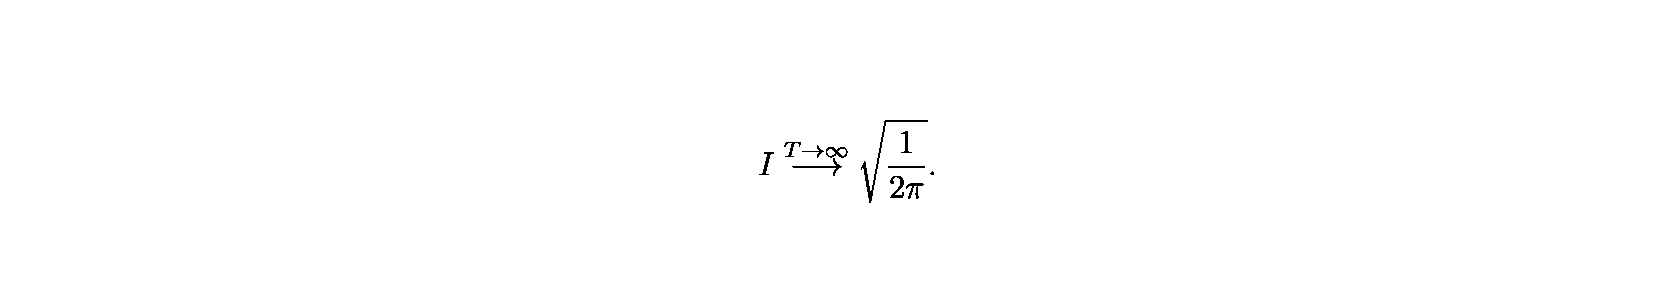

In [20]:
Image.open(img_cropped_dir + "5f8f6eac29.png")

In [17]:
class MERDataset(torch.utils.data.Dataset):
    def __init__(self, img_formula_dict, transforms=None):
        self.transforms = transforms

        self.imgs_path = list(img_formula_dict.keys())
        
        self.formulas = list(img_formula_dict.values())

    def __getitem__(self, idx):
        # load images
        img_path = self.imgs_path[idx]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        if self.transforms is not None:
            img = self.transforms(img)
            img = transforms.functional.invert(img)
            
        formula = self.formulas[idx]["truth"]
        formula_encoded = self.formulas[idx]["encoded"]

        return img, formula, formula_encoded
    
    def __len__(self):
        return len(self.imgs_path)

In [18]:
def collate_fn(batch):
    batch.sort(key=lambda x: len(x[2]), reverse=True)
    
    imgs, truths, labels = zip(*batch)
    
    max_len = max([len(label) for label in labels])
    # Padding with -1, will later be replaced with the PAD token
    padded_labels = [
        label + (max_len - len(label)) * [-1]
        for label in labels
    ]
        
    return torch.concat(imgs, dim=0).unsqueeze(1), truths, torch.tensor(padded_labels, dtype=torch.long)
    

In [449]:
transforms_1 = transforms.Compose([
    #transforms.ToTensor(),
    transforms.Resize((110, 660)),
    transforms.Grayscale(num_output_channels=1),
])

In [450]:
train_dataset = MERDataset(train_dataset_dict, transforms=transforms_1)
val_dataset = MERDataset(val_dataset_dict, transforms=transforms_1)
test_dataset = MERDataset(test_dataset_dict, transforms=transforms_1)

In [474]:
train_dataset[13][1]

'L_{0} = \\Phi(w) = \\bigtriangleup\\Phi(w) ,'

# Создание архитектуры нейронной сети

In [21]:
import torch
import torch.nn as nn
from torchsummary import summary

In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
device = "cpu"

In [24]:
device

'cpu'

## Encoder - свёрточная нейронная сеть

In [25]:
# Number of bottlenecks
num_bn = 3
depth = 16
multi_block_depth = depth // 2
growth_rate = 24

In [26]:
class BottleneckBlock(nn.Module):
    def __init__(self, input_size, growth_rate, dropout_rate=0.2):
        """
        Args:
            input_size (int): Number of channels of the input
            growth_rate (int): Number of new features being added. That is the ouput
                size of the last convolutional layer.
            dropout_rate (float, optional): Probability of dropout [Default: 0.2]
        """
        super(BottleneckBlock, self).__init__()
        inter_size = num_bn * growth_rate
        self.norm1 = nn.BatchNorm2d(input_size)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(
            input_size, inter_size, kernel_size=1, stride=1, bias=False
        )
        self.norm2 = nn.BatchNorm2d(inter_size)
        self.conv2 = nn.Conv2d(
            inter_size, growth_rate, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out = self.conv1(self.relu(self.norm1(x)))
        out = self.conv2(self.relu(self.norm2(out)))
        out = self.dropout(out)
        return torch.cat([x, out], 1)

In [27]:
class TransitionBlock(nn.Module):
    def __init__(self, input_size, output_size):
        """
        Args:
            input_size (int): Number of channels of the input
            output_size (int): Number of channels of the output
        """
        super(TransitionBlock, self).__init__()
        self.norm = nn.BatchNorm2d(input_size)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(
            input_size, output_size, kernel_size=1, stride=1, bias=False
        )
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(self.relu(self.norm(x)))
        return self.pool(out)

In [28]:
class DenseBlock(nn.Module):
    """
    Dense block

    A dense block stacks several bottleneck blocks.
    """

    def __init__(self, input_size, growth_rate, depth, dropout_rate=0.2):
        """
        Args:
            input_size (int): Number of channels of the input
            growth_rate (int): Number of new features being added per bottleneck block
            depth (int): Number of bottleneck blocks
            dropout_rate (float, optional): Probability of dropout [Default: 0.2]
        """
        super(DenseBlock, self).__init__()
        layers = [
            BottleneckBlock(
                input_size + i * growth_rate, growth_rate, dropout_rate=dropout_rate
            )
            for i in range(depth)
        ]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [29]:
class Encoder(nn.Module):
    def __init__(
        self, img_channels=1, num_in_features=48, dropout_rate=0.2, checkpoint=None
    ):
        """
        Args:
            img_channels (int, optional): Number of channels of the images [Default: 1]
            num_in_features (int, optional): Number of channels that are created from
                the input to feed to the first dense block [Default: 48]
            dropout_rate (float, optional): Probability of dropout [Default: 0.2]
            checkpoint (dict, optional): State dictionary to be loaded
        """
        super(Encoder, self).__init__()
        self.conv0 = nn.Conv2d(
            img_channels,
            num_in_features,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )
        self.norm0 = nn.BatchNorm2d(num_in_features)
        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        num_features = num_in_features
        self.block1 = DenseBlock(
            num_features,
            growth_rate=growth_rate,
            depth=depth,
            dropout_rate=dropout_rate,
        )
        num_features = num_features + depth * growth_rate
        self.trans1 = TransitionBlock(num_features, num_features // 2)
        num_features = num_features // 2
        self.block2 = DenseBlock(
            num_features,
            growth_rate=growth_rate,
            depth=depth,
            dropout_rate=dropout_rate,
        )

        num_features = num_features + depth * growth_rate
        self.trans2_norm = nn.BatchNorm2d(num_features)
        self.trans2_relu = nn.ReLU(inplace=True)
        self.trans2_conv = nn.Conv2d(
            num_features, num_features // 2, kernel_size=1, stride=1, bias=False
        )
        self.trans2_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.multi_block = DenseBlock(
            num_features,
            growth_rate=growth_rate,
            depth=multi_block_depth,
            dropout_rate=dropout_rate,
        )
        num_features = num_features // 2
        self.block3 = DenseBlock(
            num_features,
            growth_rate=growth_rate,
            depth=depth,
            dropout_rate=dropout_rate,
        )

        if checkpoint is not None:
            self.load_state_dict(checkpoint)

    def forward(self, x):
        out = self.conv0(x)
        out = self.relu(self.norm0(out))
        out = self.max_pool(out)
        out = self.block1(out)
        out = self.trans1(out)
        out = self.block2(out)
        out_before_trans2 = self.trans2_relu(self.trans2_norm(out))
        out_A = self.trans2_conv(out_before_trans2)
        out_A = self.trans2_pool(out_A)
        out_A = self.block3(out_A)
        out_B = self.multi_block(out_before_trans2)

        return out_A, out_B

In [30]:
enc = Encoder()

In [31]:
enc.to(device);

In [32]:
sample = torch.zeros(10, 1, 120, 660, device=device)

In [33]:
low_res, high_res = enc(sample)

In [34]:
low_res_shape = low_res.shape
low_res_shape

torch.Size([10, 684, 7, 41])

In [35]:
high_res_shape = high_res.shape
high_res_shape

torch.Size([10, 792, 15, 82])

## Decoder - рекуррентная нейронная сеть с механизмом внимания

In [239]:
n = 256
n_prime = 512
decoder_conv_filters = 256
gru_hidden_size = 256
embedding_dim = 256

In [240]:
class CoverageAttention(nn.Module):
    # input_size = C
    # output_size = q
    # attn_size = L = H * W
    def __init__(
        self,
        input_size,
        output_size,
        attn_size,
        kernel_size,
        padding=0,
        device=device,
    ):
        """
        Args:
            input_size (int): Number of channels of the input
            output_size (int): Number of channels of the coverage
            attn_size (int): Length of the annotation vector
            kernel_size (int): Kernel size of the 1D convolutional layer
            padding (int, optional): Padding of the 1D convolutional layer [Default: 0]
            device (torch.device, optional): Device for the tensors
        """
        super(CoverageAttention, self).__init__()
        self.alpha = None
        self.conv = nn.Conv2d(1, output_size, kernel_size=kernel_size, padding=padding)
        self.U_a = nn.Parameter(torch.empty((n_prime, input_size)))
        self.U_f = nn.Parameter(torch.empty((n_prime, output_size)))
        self.nu_attn = nn.Parameter(torch.empty(n_prime))
        self.input_size = input_size
        self.output_size = output_size
        self.attn_size = attn_size
        self.device = device
        nn.init.xavier_normal_(self.U_a)
        nn.init.xavier_normal_(self.U_f)
        # Xavier requires at least a 2D tensor.
        nn.init.xavier_normal_(self.nu_attn.unsqueeze(0))

    def reset_alpha(self, batch_size):
        self.alpha = torch.zeros((batch_size, 1, self.attn_size), device=self.device)

    def forward(self, x, u_pred):
        batch_size = x.size(0)
        if self.alpha is None:
            self.reset_alpha(batch_size)
        # Change the dimensions to make it possible to apply a 2D convolution
        # From: (batch_size x L)
        # To: (batch_size x H x W)
        alpha_sum = self.alpha.sum(1).view(batch_size, x.size(2), x.size(3))
        conv_out = self.conv(alpha_sum.unsqueeze(1))
        # Change dimensions back
        # From: (batch_size x output_size x H x W)
        # To: (batch_size x output_size x L)
        conv_out = conv_out.view(batch_size, self.output_size, -1)
        # Change the dimensions
        # From: (batch_size x C x H x W)
        # To: (batch_size x C x L)
        a = x.view(batch_size, x.size(1), -1)
        u_a = torch.matmul(self.U_a, a)
        u_f = torch.matmul(self.U_f, conv_out)
        # u_pred is expanded from (batch_size x n_prime)
        # to (batch_size x n_prime x L) because there are L components to which
        # the same u_pred is added.
        u_pred_expanded = u_pred.unsqueeze(2).expand_as(u_a)
        tan_res = torch.tanh(u_pred_expanded + u_a + u_f)
        e_t = torch.matmul(self.nu_attn, tan_res)
        alpha_t = torch.softmax(e_t, dim=1)
        self.alpha = torch.cat((self.alpha, alpha_t.detach().unsqueeze(1)), dim=1)
        # alpha_t: (batch_size x L)
        # a: (batch_size x C x L) but need (C x batch_size x L) for
        # element-wise multiplication. So transpose them.
        cA_t_L = alpha_t * a.transpose(0, 1)
        # Transpose back
        return cA_t_L.transpose(0, 1).sum(2)

In [241]:
class Maxout(nn.Module):
    def __init__(self, pool_size):
        """
        Args:
            pool_size (int): Number of elements per pool
        """
        super(Maxout, self).__init__()
        self.pool_size = pool_size

    def forward(self, x):
        [*shape, last] = x.size()
        out = x.view(*shape, last // self.pool_size, self.pool_size)
        out, _ = out.max(-1)
        return out

In [242]:
class Decoder(nn.Module):
    def __init__(
        self,
        num_classes,
        low_res_shape,
        high_res_shape,
        hidden_size=256,
        embedding_dim=256,
        checkpoint=None,
        device=device,
    ):
        """
        Args:
            num_classes (int): Number of symbol classes
            low_res_shape ((int, int, int)): Shape of the low resolution annotations
                i.e. (C, W, H)
            high_res_shape ((int, int, int)): Shape of the high resolution annotations
                i.e. (C_prime, 2W, 2H)
            hidden_size (int, optional): Hidden size of the GRU [Default: 256]
            embedding_dim (int, optional): Dimension of the embedding [Default: 256]
            checkpoint (dict, optional): State dictionary to be loaded
            device (torch.device, optional): Device for the tensors
        """
        super(Decoder, self).__init__()
        C = low_res_shape[1]
        C_prime = high_res_shape[1]
        context_size = C + C_prime
        self.embedding = nn.Embedding(num_classes, embedding_dim)
        self.gru1 = nn.GRU(
            input_size=embedding_dim, hidden_size=hidden_size, batch_first=True
        )
        self.gru2 = nn.GRU(
            input_size=context_size, hidden_size=hidden_size, batch_first=True
        )
        # L = H * W
        low_res_attn_size = low_res_shape[2] * low_res_shape[3]
        high_res_attn_size = high_res_shape[2] * high_res_shape[3]
        self.coverage_attn_low = CoverageAttention(
            C,
            decoder_conv_filters,
            attn_size=low_res_attn_size,
            kernel_size=(11, 11),
            padding=5,
            device=device,
        )
        self.coverage_attn_high = CoverageAttention(
            C_prime,
            decoder_conv_filters,
            attn_size=high_res_attn_size,
            kernel_size=(7, 7),
            padding=3,
            device=device,
        )
        self.W_o = nn.Parameter(torch.empty((num_classes, embedding_dim // 2)))
        self.W_s = nn.Parameter(torch.empty((embedding_dim, hidden_size)))
        self.W_c = nn.Parameter(torch.empty((embedding_dim, context_size)))
        self.U_pred = nn.Parameter(torch.empty((n_prime, n)))
        self.maxout = Maxout(2)
        self.hidden_size = hidden_size
        nn.init.xavier_normal_(self.W_o)
        nn.init.xavier_normal_(self.W_s)
        nn.init.xavier_normal_(self.W_c)
        nn.init.xavier_normal_(self.U_pred)

        if checkpoint is not None:
            self.load_state_dict(checkpoint)

    def init_hidden(self, batch_size):
        return torch.zeros((1, batch_size, self.hidden_size))

    def reset(self, batch_size):
        self.coverage_attn_low.reset_alpha(batch_size)
        self.coverage_attn_high.reset_alpha(batch_size)

    # Unsqueeze and squeeze are used to add and remove the seq_len dimension,
    # which is always 1 since only the previous symbol is provided, not a sequence.
    # The inputs that are multiplied by the weights are transposed to get
    # (m x batch_size) instead of (batch_size x m). The result of the
    # multiplication is tranposed back.
    def forward(self, x, hidden, low_res, high_res):
        embedded = self.embedding(x)
        pred, _ = self.gru1(embedded, hidden)
        # u_pred is computed here instead of in the coverage attention, because the
        # weight U_pred is shared and the coverage attention does not use pred for
        # anything else. This avoids computing it twice.
        u_pred = torch.matmul(self.U_pred, pred.squeeze(1).t()).t()
        context_low = self.coverage_attn_low(low_res, u_pred)
        context_high = self.coverage_attn_high(high_res, u_pred)
        context = torch.cat((context_low, context_high), dim=1)
        new_hidden, _ = self.gru2(context.unsqueeze(1), pred.transpose(0, 1))
        w_s = torch.matmul(self.W_s, new_hidden.squeeze(1).t()).t()
        w_c = torch.matmul(self.W_c, context.t()).t()
        out = embedded.squeeze(1) + w_s + w_c
        out = self.maxout(out)
        out = torch.matmul(self.W_o, out.t()).t()
        return out, new_hidden.transpose(0, 1)

In [243]:
dec = Decoder(112, low_res_shape, high_res_shape)

In [244]:
dec.to(device);

In [245]:
hidden = dec.init_hidden(10).to(device)

In [246]:
expected = torch.zeros(10, 250, dtype=torch.long).to(device)
batch_max_len = expected.size(1)
use_teacher_forcing = True

In [247]:
sequence = torch.full(
                (10, 1),
                1,
                dtype=torch.long,
                device=device,
            )
previous = expected[:, 0] if use_teacher_forcing else sequence[:, -1]
previous = previous.view(-1, 1)

In [248]:
decoded_values = []

In [249]:
out, hidden = dec(previous, hidden, low_res, high_res)
hidden = hidden.detach()
_, top1_id = torch.topk(out, 1)
sequence = torch.cat((sequence, top1_id), dim=1)
decoded_values.append(out)

RuntimeError: shape '[10, 7, 41]' is invalid for input of size 60

# Обучение нейронной сети

In [316]:
import multiprocessing
from torch.utils.tensorboard import SummaryWriter
from torch import optim
import random
import time

In [317]:
from torcheval.metrics.functional import word_error_rate

In [318]:
writer = SummaryWriter()

In [319]:
batch_size = 2
num_workers = multiprocessing.cpu_count()
num_epochs = 5
print_epochs = 1
learning_rate = 1e-3
lr_epochs = 20
lr_factor = 0.1
weight_decay = 1e-4
max_grad_norm = 5.0
dropout_rate = 0.2
teacher_forcing_ratio = 0.5
seed = 1234

In [320]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                            drop_last=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            drop_last=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                            drop_last=False, collate_fn=collate_fn)

In [321]:
# Number of bottlenecks
num_bn = 2
depth = 8
multi_block_depth = depth // 2
growth_rate = 12

In [322]:
class BottleneckBlock(nn.Module):
    def __init__(self, input_size, growth_rate, dropout_rate=0.2):
        """
        Args:
            input_size (int): Number of channels of the input
            growth_rate (int): Number of new features being added. That is the ouput
                size of the last convolutional layer.
            dropout_rate (float, optional): Probability of dropout [Default: 0.2]
        """
        super(BottleneckBlock, self).__init__()
        inter_size = num_bn * growth_rate
        self.norm1 = nn.BatchNorm2d(input_size)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(
            input_size, inter_size, kernel_size=1, stride=1, bias=False
        )
        self.norm2 = nn.BatchNorm2d(inter_size)
        self.conv2 = nn.Conv2d(
            inter_size, growth_rate, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out = self.conv1(self.relu(self.norm1(x)))
        out = self.conv2(self.relu(self.norm2(out)))
        out = self.dropout(out)
        return torch.cat([x, out], 1)

In [323]:
class TransitionBlock(nn.Module):
    def __init__(self, input_size, output_size):
        """
        Args:
            input_size (int): Number of channels of the input
            output_size (int): Number of channels of the output
        """
        super(TransitionBlock, self).__init__()
        self.norm = nn.BatchNorm2d(input_size)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(
            input_size, output_size, kernel_size=1, stride=1, bias=False
        )
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(self.relu(self.norm(x)))
        return self.pool(out)

In [324]:
class DenseBlock(nn.Module):
    """
    Dense block

    A dense block stacks several bottleneck blocks.
    """

    def __init__(self, input_size, growth_rate, depth, dropout_rate=0.2):
        """
        Args:
            input_size (int): Number of channels of the input
            growth_rate (int): Number of new features being added per bottleneck block
            depth (int): Number of bottleneck blocks
            dropout_rate (float, optional): Probability of dropout [Default: 0.2]
        """
        super(DenseBlock, self).__init__()
        layers = [
            BottleneckBlock(
                input_size + i * growth_rate, growth_rate, dropout_rate=dropout_rate
            )
            for i in range(depth)
        ]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [325]:
class Encoder(nn.Module):
    def __init__(
        self, img_channels=1, num_in_features=48, dropout_rate=0.2, checkpoint=None
    ):
        """
        Args:
            img_channels (int, optional): Number of channels of the images [Default: 1]
            num_in_features (int, optional): Number of channels that are created from
                the input to feed to the first dense block [Default: 48]
            dropout_rate (float, optional): Probability of dropout [Default: 0.2]
            checkpoint (dict, optional): State dictionary to be loaded
        """
        super(Encoder, self).__init__()
        self.conv0 = nn.Conv2d(
            img_channels,
            num_in_features,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )
        self.norm0 = nn.BatchNorm2d(num_in_features)
        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        num_features = num_in_features
        self.block1 = DenseBlock(
            num_features,
            growth_rate=growth_rate,
            depth=depth,
            dropout_rate=dropout_rate,
        )
        num_features = num_features + depth * growth_rate
        self.trans1 = TransitionBlock(num_features, num_features // 2)
        num_features = num_features // 2
        self.block2 = DenseBlock(
            num_features,
            growth_rate=growth_rate,
            depth=depth,
            dropout_rate=dropout_rate,
        )

        num_features = num_features + depth * growth_rate
        self.trans2_norm = nn.BatchNorm2d(num_features)
        self.trans2_relu = nn.ReLU(inplace=True)
        self.trans2_conv = nn.Conv2d(
            num_features, num_features // 2, kernel_size=1, stride=1, bias=False
        )
        self.trans2_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.multi_block = DenseBlock(
            num_features,
            growth_rate=growth_rate,
            depth=multi_block_depth,
            dropout_rate=dropout_rate,
        )
        num_features = num_features // 2
        self.block3 = DenseBlock(
            num_features,
            growth_rate=growth_rate,
            depth=depth,
            dropout_rate=dropout_rate,
        )

        if checkpoint is not None:
            self.load_state_dict(checkpoint)

    def forward(self, x):
        out = self.conv0(x)
        out = self.relu(self.norm0(out))
        out = self.max_pool(out)
        out = self.block1(out)
        out = self.trans1(out)
        out = self.block2(out)
        out_before_trans2 = self.trans2_relu(self.trans2_norm(out))
        out_A = self.trans2_conv(out_before_trans2)
        out_A = self.trans2_pool(out_A)
        out_A = self.block3(out_A)
        out_B = self.multi_block(out_before_trans2)

        return out_A, out_B

In [326]:
encoder = Encoder(dropout_rate=dropout_rate)

In [327]:
encoder.to(device);

In [328]:
encoder1 = Encoder(dropout_rate=dropout_rate)

In [329]:
sample = torch.zeros(batch_size, 1, 30, 100, device=device)
low, high = encoder(sample)

In [330]:
low_res_shape = low.shape
high_res_shape = high.shape

In [351]:
low_res_shape

torch.Size([2, 180, 1, 6])

In [332]:
n = 128
n_prime = 256
decoder_conv_filters = 64
gru_hidden_size = 128
embedding_dim = 128

In [333]:
class CoverageAttention(nn.Module):
    # input_size = C
    # output_size = q
    # attn_size = L = H * W
    def __init__(
        self,
        input_size,
        output_size,
        attn_size,
        kernel_size,
        padding=0,
        device=device,
    ):
        """
        Args:
            input_size (int): Number of channels of the input
            output_size (int): Number of channels of the coverage
            attn_size (int): Length of the annotation vector
            kernel_size (int): Kernel size of the 1D convolutional layer
            padding (int, optional): Padding of the 1D convolutional layer [Default: 0]
            device (torch.device, optional): Device for the tensors
        """
        super(CoverageAttention, self).__init__()
        self.alpha = None
        self.conv = nn.Conv2d(1, output_size, kernel_size=kernel_size, padding=padding)
        self.U_a = nn.Parameter(torch.empty((n_prime, input_size)))
        self.U_f = nn.Parameter(torch.empty((n_prime, output_size)))
        self.nu_attn = nn.Parameter(torch.empty(n_prime))
        self.input_size = input_size
        self.output_size = output_size
        self.attn_size = attn_size
        self.device = device
        nn.init.xavier_normal_(self.U_a)
        nn.init.xavier_normal_(self.U_f)
        # Xavier requires at least a 2D tensor.
        nn.init.xavier_normal_(self.nu_attn.unsqueeze(0))

    def reset_alpha(self, batch_size):
        self.alpha = torch.zeros((batch_size, 1, self.attn_size), device=self.device)

    def forward(self, x, u_pred):
        batch_size = x.size(0)
        if self.alpha is None:
            self.reset_alpha(batch_size)
        # Change the dimensions to make it possible to apply a 2D convolution
        # From: (batch_size x L)
        # To: (batch_size x H x W)
        alpha_sum = self.alpha.sum(1).view(batch_size, x.size(2), x.size(3))
        conv_out = self.conv(alpha_sum.unsqueeze(1))
        # Change dimensions back
        # From: (batch_size x output_size x H x W)
        # To: (batch_size x output_size x L)
        conv_out = conv_out.view(batch_size, self.output_size, -1)
        # Change the dimensions
        # From: (batch_size x C x H x W)
        # To: (batch_size x C x L)
        a = x.view(batch_size, x.size(1), -1)
        u_a = torch.matmul(self.U_a, a)
        u_f = torch.matmul(self.U_f, conv_out)
        # u_pred is expanded from (batch_size x n_prime)
        # to (batch_size x n_prime x L) because there are L components to which
        # the same u_pred is added.
        u_pred_expanded = u_pred.unsqueeze(2).expand_as(u_a)
        tan_res = torch.tanh(u_pred_expanded + u_a + u_f)
        e_t = torch.matmul(self.nu_attn, tan_res)
        alpha_t = torch.softmax(e_t, dim=1)
        self.alpha = torch.cat((self.alpha, alpha_t.detach().unsqueeze(1)), dim=1)
        # alpha_t: (batch_size x L)
        # a: (batch_size x C x L) but need (C x batch_size x L) for
        # element-wise multiplication. So transpose them.
        cA_t_L = alpha_t * a.transpose(0, 1)
        # Transpose back
        return cA_t_L.transpose(0, 1).sum(2)

In [334]:
class Maxout(nn.Module):
    def __init__(self, pool_size):
        """
        Args:
            pool_size (int): Number of elements per pool
        """
        super(Maxout, self).__init__()
        self.pool_size = pool_size

    def forward(self, x):
        [*shape, last] = x.size()
        out = x.view(*shape, last // self.pool_size, self.pool_size)
        out, _ = out.max(-1)
        return out

In [335]:
class Decoder(nn.Module):
    def __init__(
        self,
        num_classes,
        low_res_shape,
        high_res_shape,
        hidden_size=128,
        embedding_dim=128,
        checkpoint=None,
        device=device,
    ):
        """
        Args:
            num_classes (int): Number of symbol classes
            low_res_shape ((int, int, int)): Shape of the low resolution annotations
                i.e. (C, W, H)
            high_res_shape ((int, int, int)): Shape of the high resolution annotations
                i.e. (C_prime, 2W, 2H)
            hidden_size (int, optional): Hidden size of the GRU [Default: 256]
            embedding_dim (int, optional): Dimension of the embedding [Default: 256]
            checkpoint (dict, optional): State dictionary to be loaded
            device (torch.device, optional): Device for the tensors
        """
        super(Decoder, self).__init__()
        C = low_res_shape[1]
        C_prime = high_res_shape[1]
        context_size = C + C_prime
        self.embedding = nn.Embedding(num_classes, embedding_dim)
        self.gru1 = nn.GRU(
            input_size=embedding_dim, hidden_size=hidden_size, batch_first=True
        )
        self.gru2 = nn.GRU(
            input_size=context_size, hidden_size=hidden_size, batch_first=True
        )
        # L = H * W
        low_res_attn_size = low_res_shape[2] * low_res_shape[3]
        high_res_attn_size = high_res_shape[2] * high_res_shape[3]
        self.coverage_attn_low = CoverageAttention(
            C,
            decoder_conv_filters,
            attn_size=low_res_attn_size,
            kernel_size=(11, 11),
            padding=5,
            device=device,
        )
        self.coverage_attn_high = CoverageAttention(
            C_prime,
            decoder_conv_filters,
            attn_size=high_res_attn_size,
            kernel_size=(7, 7),
            padding=3,
            device=device,
        )
        self.W_o = nn.Parameter(torch.empty((num_classes, embedding_dim // 2)))
        self.W_s = nn.Parameter(torch.empty((embedding_dim, hidden_size)))
        self.W_c = nn.Parameter(torch.empty((embedding_dim, context_size)))
        self.U_pred = nn.Parameter(torch.empty((n_prime, n)))
        self.maxout = Maxout(2)
        self.hidden_size = hidden_size
        nn.init.xavier_normal_(self.W_o)
        nn.init.xavier_normal_(self.W_s)
        nn.init.xavier_normal_(self.W_c)
        nn.init.xavier_normal_(self.U_pred)

        if checkpoint is not None:
            self.load_state_dict(checkpoint)

    def init_hidden(self, batch_size):
        return torch.zeros((1, batch_size, self.hidden_size))

    def reset(self, batch_size):
        self.coverage_attn_low.reset_alpha(batch_size)
        self.coverage_attn_high.reset_alpha(batch_size)

    # Unsqueeze and squeeze are used to add and remove the seq_len dimension,
    # which is always 1 since only the previous symbol is provided, not a sequence.
    # The inputs that are multiplied by the weights are transposed to get
    # (m x batch_size) instead of (batch_size x m). The result of the
    # multiplication is tranposed back.
    def forward(self, x, hidden, low_res, high_res):
        embedded = self.embedding(x)
        pred, _ = self.gru1(embedded, hidden)
        # u_pred is computed here instead of in the coverage attention, because the
        # weight U_pred is shared and the coverage attention does not use pred for
        # anything else. This avoids computing it twice.
        u_pred = torch.matmul(self.U_pred, pred.squeeze(1).t()).t()
        context_low = self.coverage_attn_low(low_res, u_pred)
        context_high = self.coverage_attn_high(high_res, u_pred)
        context = torch.cat((context_low, context_high), dim=1)
        new_hidden, _ = self.gru2(context.unsqueeze(1), pred.transpose(0, 1))
        w_s = torch.matmul(self.W_s, new_hidden.squeeze(1).t()).t()
        w_c = torch.matmul(self.W_c, context.t()).t()
        out = embedded.squeeze(1) + w_s + w_c
        out = self.maxout(out)
        out = torch.matmul(self.W_o, out.t()).t()
        return out, new_hidden.transpose(0, 1)

In [336]:
decoder = Decoder(len(id_to_token), low_res_shape, high_res_shape)

In [337]:
decoder1 = Decoder(len(id_to_token), low_res_shape, high_res_shape)

In [338]:
decoder.to(device);

In [339]:
encoder_params = [param for param in encoder.parameters() if param.requires_grad]

In [340]:
decoder_params = [param for param in decoder.parameters() if param.requires_grad]

In [341]:
params_to_optimise = [*encoder_params, *decoder_params]

In [342]:
criterion = nn.CrossEntropyLoss()

In [343]:
optimiser = optim.Adadelta(
        params_to_optimise, lr=learning_rate, weight_decay=weight_decay
    )

In [344]:
0.2 *len(train_dataloader)

12752.0

In [346]:
def run_epoch(
    data_loader,
    enc,
    dec,
    epoch_text,
    criterion,
    optimiser,
    teacher_forcing_ratio,
    max_grad_norm,
    device,
    train=True,
):
    # Disables autograd during validation mode
    torch.set_grad_enabled(train)
    if train:
        enc.train()
        dec.train()
    else:
        enc.eval()
        dec.eval()

    losses = []
    grad_norms = []
    correct_symbols = 0
    total_symbols = 0
    
    covered_data = 0

    with tqdm(
        desc="{} ({})".format(epoch_text, "Train" if train else "Validation"),
        total=int(0.25*len(data_loader)),
        dynamic_ncols=True,
        leave=False,
    ) as pbar:
        for d in data_loader:
            input, truth, expected = d
            input = input.to(device)
            # The last batch may not be a full batch
            curr_batch_size = len(input)
            expected = expected.to(device)
            batch_max_len = expected.size(1)
            # Replace -1 with the PAD token
            expected[expected == -1] = token_to_id[PAD]
            enc_low_res, enc_high_res = enc(input)
            # Decoder needs to be reset, because the coverage attention (alpha)
            # only applies to the current image.
            dec.reset(curr_batch_size)
            hidden = dec.init_hidden(curr_batch_size).to(device)
            # Starts with a START token
            sequence = torch.full(
                (curr_batch_size, 1),
                token_to_id[START],
                dtype=torch.long,
                device=device,
            )
            # The teacher forcing is done per batch, not symbol
            use_teacher_forcing = train and random.random() < teacher_forcing_ratio
            decoded_values = []
            for i in range(batch_max_len - 1):
                previous = expected[:, i] if use_teacher_forcing else sequence[:, -1]
                previous = previous.view(-1, 1)
                out, hidden = dec(previous, hidden, enc_low_res, enc_high_res)
                hidden = hidden.detach()
                _, top1_id = torch.topk(out, 1)
                sequence = torch.cat((sequence, top1_id), dim=1)
                decoded_values.append(out)

            decoded_values = torch.stack(decoded_values, dim=2).to(device)
            # decoded_values does not contain the start symbol
            loss = criterion(decoded_values, expected[:, 1:])

            if train:
                optim_params = [
                    p
                    for param_group in optimiser.param_groups
                    for p in param_group["params"]
                ]
                optimiser.zero_grad()
                loss.backward()
                # Clip gradients, it returns the total norm of all parameters
                grad_norm = nn.utils.clip_grad_norm_(
                    optim_params, max_norm=max_grad_norm
                )
                grad_norms.append(grad_norm.detach().cpu())
                optimiser.step()

            losses.append(loss.item())
            correct_symbols += torch.sum(sequence == expected, dim=(0, 1)).item()
            total_symbols += expected.numel()
            pbar.update(curr_batch_size)
            
            covered_data += 2
            
            if covered_data >= int(0.25 * len(data_loader)):
                break

    result = {
        "loss": np.mean(losses),
        "correct_symbols": correct_symbols,
        "total_symbols": total_symbols,
    }
    if train:
        result["grad_norm"] = np.mean(grad_norms)

    return result

In [347]:
import os
import torch
from torch.utils.tensorboard import SummaryWriter

use_cuda = torch.cuda.is_available()

default_checkpoint = {
    "epoch": 0,
    "train_losses": [],
    "train_wer": [],
    "validation_losses": [],
    "validation_wer": [],
    "test_losses": [],
    "test_wer": [],
    "lr": [],
    "grad_norm": [],
    "model": {},
}


def save_checkpoint(checkpoint, dir="./checkpoints", prefix=""):
    # Padded to 4 digits because of lexical sorting of numbers.
    # e.g. 0009.pth
    filename = "{prefix}{num:0>4}.pth".format(num=checkpoint["epoch"], prefix=prefix)
    if not os.path.exists(dir):
        os.mkdir(dir)
    torch.save(checkpoint, os.path.join(dir, filename))


def load_checkpoint(path, cuda=use_cuda):
    if cuda:
        return torch.load(path)
    else:
        # Load GPU model on CPU
        return torch.load(path, map_location=lambda storage, loc: storage)


def init_tensorboard(name="", base_dir="./tensorboard"):
    return SummaryWriter(os.path.join(base_dir, name))


def write_tensorboard(
    writer,
    epoch,
    grad_norm,
    train_loss,
    train_wer,
    validation_loss,
    validation_wer,
    test_loss,
    test_wer,
    encoder,
    decoder,
):
    writer.add_scalar("train_loss", train_loss, epoch)
    writer.add_scalar("train_wer", train_wer, epoch)
    writer.add_scalar("validation_loss", validation_loss, epoch)
    writer.add_scalar("validation_wer", validation_wer, epoch)
    writer.add_scalar("test_loss", test_loss, epoch)
    writer.add_scalar("test_wer", test_wer, epoch)
    writer.add_scalar("grad_norm", grad_norm, epoch)

    for name, param in encoder.named_parameters():
        writer.add_histogram(
            "encoder/{}".format(name), param.detach().cpu().numpy(), epoch
        )
        if param.grad is not None:
            writer.add_histogram(
                "encoder/{}/grad".format(name), param.grad.detach().cpu().numpy(), epoch
            )

    for name, param in decoder.named_parameters():
        writer.add_histogram(
            "decoder/{}".format(name), param.detach().cpu().numpy(), epoch
        )
        if param.grad is not None:
            writer.add_histogram(
                "decoder/{}/grad".format(name), param.grad.detach().cpu().numpy(), epoch
            )


In [348]:
def train(
    enc,
    dec,
    optimiser,
    criterion,
    train_data_loader,
    validation_data_loader,
    test_data_loader,
    device,
    teacher_forcing_ratio=teacher_forcing_ratio,
    lr_scheduler=None,
    num_epochs=4,
    print_epochs=None,
    checkpoint=default_checkpoint,
    prefix="",
    max_grad_norm=max_grad_norm,
):
    if print_epochs is None:
        print_epochs = num_epochs

    writer = init_tensorboard(name=prefix.strip("-"))
    start_epoch = checkpoint["epoch"]
    train_accuracy = checkpoint["train_wer"]
    train_losses = checkpoint["train_losses"]
    validation_accuracy = checkpoint["validation_wer"]
    validation_losses = checkpoint["validation_losses"]
    test_accuracy = checkpoint["test_wer"]
    test_losses = checkpoint["test_losses"]
    learning_rates = checkpoint["lr"]
    grad_norms = checkpoint["grad_norm"]

    for epoch in range(num_epochs):
        start_time = time.time()

        if lr_scheduler:
            lr_scheduler.step()

        epoch_text = "[{current:>{pad}}/{end}] Epoch {epoch}".format(
            current=epoch + 1,
            end=num_epochs,
            epoch=start_epoch + epoch + 1,
            pad=len(str(num_epochs)),
        )

        train_result = run_epoch(
            train_data_loader,
            enc,
            dec,
            epoch_text,
            criterion,
            optimiser,
            teacher_forcing_ratio,
            max_grad_norm,
            device,
            train=True,
        )
        train_losses.append(train_result["loss"])
        grad_norms.append(train_result["grad_norm"])
        train_epoch_accuracy = (
            train_result["correct_symbols"] / train_result["total_symbols"]
        )
        train_accuracy.append(train_epoch_accuracy)
        epoch_lr = lr_scheduler.get_lr()[0]
        learning_rates.append(epoch_lr)

        validation_result = run_epoch(
            validation_data_loader,
            enc,
            dec,
            epoch_text,
            criterion,
            optimiser,
            teacher_forcing_ratio,
            max_grad_norm,
            device,
            train=False,
        )
        validation_losses.append(validation_result["loss"])
        validation_epoch_accuracy = (
            validation_result["correct_symbols"] / validation_result["total_symbols"]
        )
        validation_accuracy.append(validation_epoch_accuracy)
        
        test_result = run_epoch(
            test_data_loader,
            enc,
            dec,
            epoch_text,
            criterion,
            optimiser,
            teacher_forcing_ratio,
            max_grad_norm,
            device,
            train=False,
        )
        test_losses.append(test_result["loss"])
        test_epoch_accuracy = (
            test_result["correct_symbols"] / test_result["total_symbols"]
        )
        test_accuracy.append(test_epoch_accuracy)

        save_checkpoint(
            {
                "epoch": start_epoch + epoch + 1,
                "train_losses": train_losses,
                "train_wer": train_accuracy,
                "validation_losses": validation_losses,
                "validation_wer": validation_accuracy,
                "lr": learning_rates,
                "grad_norm": grad_norms,
                "model": {"encoder": enc.state_dict(), "decoder": dec.state_dict()},
                "optimiser": optimiser.state_dict(),
            },
            prefix=prefix,
        )

        elapsed_time = time.time() - start_time
        elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
        if epoch % print_epochs == 0 or epoch == num_epochs - 1:
            print(
                (
                    "{epoch_text}: "
                    "Train WER = {train_accuracy:.5f}, "
                    "Train Loss = {train_loss:.5f}, "
                    "Validation WER = {validation_accuracy:.5f}, "
                    "Validation Loss = {validation_loss:.5f}, "
                    "Test WER = {validation_accuracy:.5f}, "
                    "Test Loss = {validation_loss:.5f}, "
                    "lr = {lr} "
                    "(time elapsed {time})"
                ).format(
                    epoch_text=epoch_text,
                    train_accuracy=train_epoch_accuracy,
                    train_loss=train_result["loss"],
                    validation_accuracy=validation_epoch_accuracy,
                    validation_loss=validation_result["loss"],
                    test_accuracy=test_epoch_accuracy,
                    test_loss=test_result["loss"],
                    lr=epoch_lr,
                    time=elapsed_time,
                )
            )
            write_tensorboard(
                writer,
                start_epoch + epoch + 1,
                train_result["grad_norm"],
                train_result["loss"],
                train_epoch_accuracy,
                validation_result["loss"],
                validation_epoch_accuracy,
                test_result["loss"],
                test_epoch_accuracy,
                enc,
                dec,
            )

In [349]:
run_epoch(
    train_dataloader,
    encoder,
    decoder,
    "",
    criterion,
    optimiser,
    teacher_forcing_ratio,
    max_grad_norm,
    device
)

KeyboardInterrupt: 

In [350]:
lr_scheduler = optim.lr_scheduler.StepLR(
        optimiser, step_size=lr_epochs, gamma=lr_factor
    )

train(
    encoder,
    decoder,
    optimiser,
    criterion,
    train_dataloader,
    val_dataloader,
    test_dataloader,
    teacher_forcing_ratio=teacher_forcing_ratio,
    lr_scheduler=lr_scheduler,
    print_epochs=print_epochs,
    device=device,
    num_epochs=num_epochs,
    checkpoint=default_checkpoint,
    prefix="-",
    max_grad_norm=max_grad_norm,
)

c:\ProgramData\anaconda3\envs\DL_env\Lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[1/5] Epoch 1: Train WER = 0.21368, Train Loss = 4.77855, Validation WER = 0.23438, Validation Loss = 4.12933, Test WER = 0.23438, Test Loss = 4.12933, lr = 0.001 (time elapsed 01:44:46)


[2/5] Epoch 2: Train WER = 0.27716, Train Loss = 3.86476, Validation WER = 0.26803, Validation Loss = 3.86484, Test WER = 0.26803, Test Loss = 3.86484, lr = 0.001 (time elapsed 01:43:48)


[3/5] Epoch 3: Train WER = 0.28865, Train Loss = 3.70246, Validation WER = 0.27427, Validation Loss = 3.72644, Test WER = 0.27427, Test Loss = 3.72644, lr = 0.001 (time elapsed 01:20:51)


[4/5] Epoch 4: Train WER = 0.29946, Train Loss = 3.62911, Validation WER = 0.26755, Validation Loss = 3.69636, Test WER = 0.26755, Test Loss = 3.69636, lr = 0.001 (time elapsed 01:21:11)


[5/5] Epoch 5: Train WER = 0.30457, Train Loss = 3.58736, Validation WER = 0.26763, Validation Loss = 3.69077, Test WER = 0.26763, Test Loss = 3.69077, lr = 0.001 (time elapsed 01:19:12)


# Анализ результатов

In [406]:
import re
import matplotlib.pyplot as plt
import skimage
from IPython.display import display, Markdown
import matplotlib.cm as cm

In [407]:
def print_predictions(preds, expected):
    header = "|  Time step  |  Expected  |"
    lines = []
    for i in range(len(expected)):
        line = "|  {t:>{pad_time}}  |  `{exp:>{pad_exp}}`  |".format(
                  t=i,
                  exp=expected[i],
                  pad_time=len("Time step"),
                  pad_exp=len("Expected")
              )
        for name, pred in preds.items():
            if i == 0:
                header += "  {}  |".format(name)
            # Tokens are put in a code block, because the special tokens are within
            # angle brackets and they would be treated as HTML tags in the markdown.
            line += "  `{pred:>{pad_pred}}`  |".format(pred=pred[i], pad_pred=len(name))
        lines.append(line)
        
    table = "{header}\n{delimiter}\n{lines}".format(header=header, delimiter=re.sub("[^|]", "-", header), lines="\n".join(lines))
    display(Markdown(table))

In [434]:
to_pil_image = transforms.ToPILImage()

def show_attention_images(img, results, batch_num, smooth=False):
    pil_img = to_pil_image(img)
    _, h, w = img.size()
    timesteps = max(res["attn_low"][batch_num].size(0) for res in results)
    num_axes = 2*len(results)
    fig, axes = plt.subplots(timesteps, num_axes, figsize=(3.5*num_axes, 3*timesteps))
    for i in range(num_axes):
        # Each result is used in two axes
        curr_res = results[i // 2]
        # The first axis is for the low resolution and the second axis for the high resolution
        attn = curr_res["attn_low"] if i % 2 == 0 else curr_res["attn_high"]
        # Resize attentions from flat to 2D (L = H x W)
        res_size = curr_res["low_res_size"] if i % 2 == 0 else curr_res["high_res_size"]
        attn = attn[batch_num].view(-1, res_size[2], res_size[3])
        _, attn_h, attn_w = attn.size()
        attn = attn.detach().cpu().numpy()
        upscale_factor = max(h // attn_h, w // attn_w)
        if i % 2 == 0:
            axes[0][i].set_title("Low resolution")
            axes[0][i].text(0.7, 1.2, curr_res["name"], transform=axes[0][i].transAxes, fontsize=15)
        else:
            axes[0][i].set_title("High resolution")
        for t in range(timesteps):
            ax = axes[t][i]
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(pil_img)
            attn_mask = (
                skimage.transform.pyramid_expand(
                    attn[t], upscale=upscale_factor)
                if smooth
                else skimage.transform.resize(attn[t], (h, w), mode="reflect", anti_aliasing=True)
            )
            attn_img = ax.imshow(attn_mask, alpha=0.7)
            attn_img.set_cmap(cm.Greys_r)
            if i % 2 == 0:
                ax.text(1.03, 0.5, "{:>5}".format(curr_res["preds"][batch_num][t]), transform=ax.transAxes, fontsize=15)

    plt.show()

In [435]:
transforms_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((120, 660)),
    transforms.Grayscale(num_output_channels=1),
])

In [436]:
def create_batch():
    dataset = MERDataset(train_dataset_dict, transforms=transforms_1)
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn,
    )
    
    data_iter = iter(data_loader)
    batch = next(data_iter)
    return batch

In [437]:
def run_batch(input, max_len, checkpoints, id_to_token, token_to_id, device=device):
    results = []
    
    for checkpoint in checkpoints:
        enc = Encoder(img_channels=1, checkpoint=checkpoint["model"]["encoder"]).to(device)
        dec = Decoder(
            len(id_to_token),
            low_res_shape,
            high_res_shape,
            checkpoint=checkpoint["model"]["decoder"],
            device=device,
        ).to(device)
        enc.eval()
        dec.eval()

        enc_low_res, enc_high_res = enc(input)
        dec.reset(batch_size)
        hidden = dec.init_hidden(batch_size).to(device)
        # Starts with a START token
        sequence = torch.full(
            (batch_size, 1),
            token_to_id[START],
            dtype=torch.long,
            device=device,
        )
        decoded_values = []
        for i in range(max_len - 1):
            previous = sequence[:, -1].view(-1, 1)
            out, hidden = dec(previous, hidden, enc_low_res, enc_high_res)
            _, top1_id = torch.topk(out, 1)
            sequence = torch.cat((sequence, top1_id), dim=1)
            decoded_values.append(out)
        decoded_values = torch.stack(decoded_values, dim=2).to(device)

        preds_decoded = [[id_to_token[tok.item()] for tok in seq] for seq in sequence]
        result = {
            "name": checkpoint["name"],
            "preds": preds_decoded,
            "attn_low": dec.coverage_attn_low.alpha,
            "attn_high": dec.coverage_attn_high.alpha,
            "low_res_size": enc_low_res.size(),
            "high_res_size": enc_high_res.size(),
        }
        results.append(result)
    
    return results

In [438]:
def show_attention(input, expected_decoded, results):
    for i in range(len(input)):
        preds = {res["name"]: res["preds"][i] for res in results}
        print_predictions(preds, expected_decoded[i])
        show_attention_images(input[i], results, batch_num=i, smooth=True)

In [439]:
def visualise_dataset(checkpoints):
    batch = create_batch()

    input = batch[0].to(device)
    expected = batch[2].to(device)
    expected[expected == -1] = token_to_id[PAD]
    expected_decoded = [[id_to_token[tok.item()] for tok in exp] for exp in expected]
    max_len = expected.size(1)

    results = run_batch(
        input, max_len, checkpoints, id_to_token, token_to_id, device=device
    )

    show_attention(input, expected_decoded, results)

In [440]:
checkpoint = load_checkpoint("./checkpoints1/-0001.pth")

C:\Users\Egor\AppData\Local\Temp\ipykernel_32524\2266363163.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path)


In [441]:
checkpoint['name'] = "High-low resolution model"

In [442]:
checkpoints = [checkpoint]

|  Time step  |  Expected  |  High-low resolution model  |
|-------------|------------|-----------------------------|
|          0  |  `   <SOS>`  |  `                    <SOS>`  |
|          1  |  `  \Delta`  |  `                        }`  |
|          2  |  `       P`  |  `                        {`  |
|          3  |  `       (`  |  `                        }`  |
|          4  |  `       x`  |  `                        {`  |
|          5  |  `       ,`  |  `                        }`  |
|          6  |  `       y`  |  `                        {`  |
|          7  |  `       )`  |  `                        }`  |
|          8  |  `      \;`  |  `                        {`  |
|          9  |  `       =`  |  `                        }`  |
|         10  |  `      \;`  |  `                        {`  |
|         11  |  `   \left`  |  `                        }`  |
|         12  |  `       (`  |  `                        {`  |
|         13  |  `       -`  |  `                        }`  |
|         14  |  `   \frac`  |  `                        {`  |
|         15  |  `       {`  |  `                        }`  |
|         16  |  `       1`  |  `                        {`  |
|         17  |  `       }`  |  `                        }`  |
|         18  |  `       {`  |  `                        {`  |
|         19  |  `       8`  |  `                        }`  |
|         20  |  `       }`  |  `                        {`  |
|         21  |  `      \:`  |  `                        }`  |
|         22  |  `       h`  |  `                        {`  |
|         23  |  `       (`  |  `                        }`  |
|         24  |  `       x`  |  `                        {`  |
|         25  |  `       )`  |  `                        }`  |
|         26  |  `      \:`  |  `                        {`  |
|         27  |  `       -`  |  `                        }`  |
|         28  |  `      \:`  |  `                        {`  |
|         29  |  `   \frac`  |  `                        }`  |
|         30  |  `       {`  |  `                        {`  |
|         31  |  `       3`  |  `                        }`  |
|         32  |  `       }`  |  `                        {`  |
|         33  |  `       {`  |  `                        }`  |
|         34  |  `       8`  |  `                        {`  |
|         35  |  `       }`  |  `                        }`  |
|         36  |  `      \:`  |  `                        {`  |
|         37  |  `       h`  |  `                        }`  |
|         38  |  `       (`  |  `                        {`  |
|         39  |  `       y`  |  `                        }`  |
|         40  |  `       )`  |  `                        {`  |
|         41  |  `  \right`  |  `                        }`  |
|         42  |  `       )`  |  `                        {`  |
|         43  |  `       P`  |  `                        }`  |
|         44  |  `       (`  |  `                        {`  |
|         45  |  `       x`  |  `                        }`  |
|         46  |  `       ,`  |  `                        {`  |
|         47  |  `       y`  |  `                        }`  |
|         48  |  `       )`  |  `                        {`  |
|         49  |  `      \:`  |  `                        }`  |
|         50  |  `       -`  |  `                        {`  |
|         51  |  `      \:`  |  `                        }`  |
|         52  |  `       i`  |  `                        {`  |
|         53  |  `   \frac`  |  `                        }`  |
|         54  |  `       {`  |  `                        {`  |
|         55  |  `\partial`  |  `                        }`  |
|         56  |  `       }`  |  `                        {`  |
|         57  |  `       {`  |  `                        }`  |
|         58  |  `\partial`  |  `                        {`  |
|         59  |  `       y`  |  `                        }`  |
|         60  |  `       ^`  |  `                        {`  |
|         61  |  `       k`  |  `                        }`  |
|         62  |  `       }`  |  `                        {`  |
|         63  |  `  \Delta`  |  `                        }`  |
|         64  |  `       P`  |  `                        {`  |
|         65  |  `       [`  |  `                        }`  |
|         66  |  `  \gamma`  |  `                        {`  |
|         67  |  `       ^`  |  `                        }`  |
|         68  |  `       j`  |  `                        {`  |
|         69  |  `       h`  |  `                        }`  |
|         70  |  `       ^`  |  `                        {`  |
|         71  |  `       k`  |  `                        }`  |
|         72  |  `       _`  |  `                        {`  |
|         73  |  `       j`  |  `                        }`  |
|         74  |  `       ]`  |  `                        {`  |
|         75  |  `       (`  |  `                        }`  |
|         76  |  `       x`  |  `                        {`  |
|         77  |  `       ,`  |  `                        }`  |
|         78  |  `       y`  |  `                        {`  |
|         79  |  `       )`  |  `                        }`  |
|         80  |  `      \;`  |  `                        {`  |
|         81  |  `      \;`  |  `                        }`  |
|         82  |  `      \;`  |  `                        {`  |
|         83  |  `       ,`  |  `                        }`  |
|         84  |  `      \l`  |  `                        {`  |
|         85  |  `       a`  |  `                        }`  |
|         86  |  `       b`  |  `                        {`  |
|         87  |  `       e`  |  `                        }`  |
|         88  |  `       l`  |  `                        {`  |
|         89  |  `       {`  |  `                        }`  |
|         90  |  `       d`  |  `                        {`  |
|         91  |  `       A`  |  `                        }`  |
|         92  |  `       }`  |  `                        {`  |
|         93  |  `   <EOS>`  |  `                        }`  |

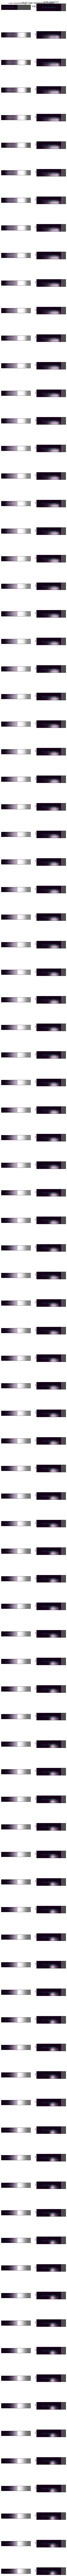

|  Time step  |  Expected  |  High-low resolution model  |
|-------------|------------|-----------------------------|
|          0  |  `   <SOS>`  |  `                    <SOS>`  |
|          1  |  `     \Pi`  |  `                    <PAD>`  |
|          2  |  `       ^`  |  `                    <PAD>`  |
|          3  |  `       {`  |  `                    <PAD>`  |
|          4  |  `     \mu`  |  `                    <PAD>`  |
|          5  |  `     \nu`  |  `                    <PAD>`  |
|          6  |  `       }`  |  `                    <PAD>`  |
|          7  |  `       (`  |  `                    <PAD>`  |
|          8  |  `       q`  |  `                    <PAD>`  |
|          9  |  `       ^`  |  `                    <PAD>`  |
|         10  |  `       2`  |  `                    <PAD>`  |
|         11  |  `       )`  |  `                    <PAD>`  |
|         12  |  `       =`  |  `                    <PAD>`  |
|         13  |  `       (`  |  `                    <PAD>`  |
|         14  |  `       q`  |  `                    <PAD>`  |
|         15  |  `       ^`  |  `                    <PAD>`  |
|         16  |  `       2`  |  `                    <PAD>`  |
|         17  |  `    \eta`  |  `                    <PAD>`  |
|         18  |  `       ^`  |  `                    <PAD>`  |
|         19  |  `       {`  |  `                    <PAD>`  |
|         20  |  `     \mu`  |  `                    <PAD>`  |
|         21  |  `     \nu`  |  `                    <PAD>`  |
|         22  |  `       }`  |  `                    <PAD>`  |
|         23  |  `       -`  |  `                    <PAD>`  |
|         24  |  `       q`  |  `                    <PAD>`  |
|         25  |  `       ^`  |  `                    <PAD>`  |
|         26  |  `     \mu`  |  `                    <PAD>`  |
|         27  |  `       q`  |  `                    <PAD>`  |
|         28  |  `       ^`  |  `                    <PAD>`  |
|         29  |  `     \nu`  |  `                    <PAD>`  |
|         30  |  `       )`  |  `                    <PAD>`  |
|         31  |  `     \Pi`  |  `                    <PAD>`  |
|         32  |  `       (`  |  `                    <PAD>`  |
|         33  |  `       q`  |  `                    <PAD>`  |
|         34  |  `       ^`  |  `                    <PAD>`  |
|         35  |  `       2`  |  `                    <PAD>`  |
|         36  |  `       )`  |  `                    <PAD>`  |
|         37  |  `       ,`  |  `                    <PAD>`  |
|         38  |  `   <EOS>`  |  `                    <PAD>`  |
|         39  |  `   <PAD>`  |  `                    <PAD>`  |
|         40  |  `   <PAD>`  |  `                    <PAD>`  |
|         41  |  `   <PAD>`  |  `                    <PAD>`  |
|         42  |  `   <PAD>`  |  `                    <PAD>`  |
|         43  |  `   <PAD>`  |  `                    <PAD>`  |
|         44  |  `   <PAD>`  |  `                    <PAD>`  |
|         45  |  `   <PAD>`  |  `                    <PAD>`  |
|         46  |  `   <PAD>`  |  `                    <PAD>`  |
|         47  |  `   <PAD>`  |  `                    <PAD>`  |
|         48  |  `   <PAD>`  |  `                    <PAD>`  |
|         49  |  `   <PAD>`  |  `                    <PAD>`  |
|         50  |  `   <PAD>`  |  `                    <PAD>`  |
|         51  |  `   <PAD>`  |  `                    <PAD>`  |
|         52  |  `   <PAD>`  |  `                    <PAD>`  |
|         53  |  `   <PAD>`  |  `                    <PAD>`  |
|         54  |  `   <PAD>`  |  `                    <PAD>`  |
|         55  |  `   <PAD>`  |  `                    <PAD>`  |
|         56  |  `   <PAD>`  |  `                    <PAD>`  |
|         57  |  `   <PAD>`  |  `                    <PAD>`  |
|         58  |  `   <PAD>`  |  `                    <PAD>`  |
|         59  |  `   <PAD>`  |  `                    <PAD>`  |
|         60  |  `   <PAD>`  |  `                    <PAD>`  |
|         61  |  `   <PAD>`  |  `                    <PAD>`  |
|         62  |  `   <PAD>`  |  `                    <PAD>`  |
|         63  |  `   <PAD>`  |  `                    <PAD>`  |
|         64  |  `   <PAD>`  |  `                    <PAD>`  |
|         65  |  `   <PAD>`  |  `                    <PAD>`  |
|         66  |  `   <PAD>`  |  `                    <PAD>`  |
|         67  |  `   <PAD>`  |  `                    <PAD>`  |
|         68  |  `   <PAD>`  |  `                    <PAD>`  |
|         69  |  `   <PAD>`  |  `                    <PAD>`  |
|         70  |  `   <PAD>`  |  `                    <PAD>`  |
|         71  |  `   <PAD>`  |  `                    <PAD>`  |
|         72  |  `   <PAD>`  |  `                    <PAD>`  |
|         73  |  `   <PAD>`  |  `                    <PAD>`  |
|         74  |  `   <PAD>`  |  `                    <PAD>`  |
|         75  |  `   <PAD>`  |  `                    <PAD>`  |
|         76  |  `   <PAD>`  |  `                    <PAD>`  |
|         77  |  `   <PAD>`  |  `                    <PAD>`  |
|         78  |  `   <PAD>`  |  `                    <PAD>`  |
|         79  |  `   <PAD>`  |  `                    <PAD>`  |
|         80  |  `   <PAD>`  |  `                    <PAD>`  |
|         81  |  `   <PAD>`  |  `                    <PAD>`  |
|         82  |  `   <PAD>`  |  `                    <PAD>`  |
|         83  |  `   <PAD>`  |  `                    <PAD>`  |
|         84  |  `   <PAD>`  |  `                    <PAD>`  |
|         85  |  `   <PAD>`  |  `                    <PAD>`  |
|         86  |  `   <PAD>`  |  `                    <PAD>`  |
|         87  |  `   <PAD>`  |  `                    <PAD>`  |
|         88  |  `   <PAD>`  |  `                    <PAD>`  |
|         89  |  `   <PAD>`  |  `                    <PAD>`  |
|         90  |  `   <PAD>`  |  `                    <PAD>`  |
|         91  |  `   <PAD>`  |  `                    <PAD>`  |
|         92  |  `   <PAD>`  |  `                    <PAD>`  |
|         93  |  `   <PAD>`  |  `                    <PAD>`  |

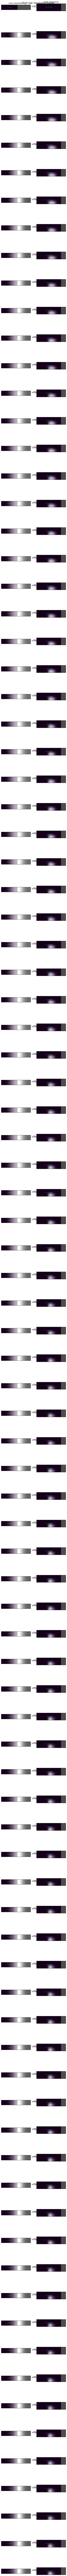

In [443]:
visualise_dataset(
    checkpoints
)

# Выводы

In [1]:
%reload_ext tensorboard

In [2]:
%tensorboard --logdir tensorboard1/